<a href="https://colab.research.google.com/github/muhammadmo/eye_diseases_classification/blob/main/Eye_diseases-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadmoosavi","key":"1fa1bc8aae4bfd517b860f44615ff8d9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

100% 734M/736M [00:36<00:00, 23.9MB/s]
100% 736M/736M [00:36<00:00, 21.3MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "eye-diseases-classification.zip"

with ZipFile(file_name,'r') as zipp:
  zipp.extractall()
print('done') 

done


In [ ]:
pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
input_folder = "/content/dataset"
output = "/content/splited_dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .1, .2)) 

Copying files: 4217 files [00:02, 1565.61 files/s]


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np             
import pandas as pd           

train_path = '/content/splited_dataset/train'
test_path = '/content/splited_dataset/test'
valid_path = '/content/splited_dataset/val'

#set defult image size
batch_size = 16
img_width = 224
img_height = 224

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rotation_range=15,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='sparse',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse', 
      batch_size=batch_size
      )

Found 2949 images belonging to 4 classes.
Found 849 images belonging to 4 classes.
Found 419 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import ResNet101V2

conv_base = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

conv_base.summary()

171317808/171317808 [==============================] - 8s 0us/step
Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                     

In [ ]:
from keras import models
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

optimizer = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model = models.Sequential()

model.add(Conv2D(3, (3, 3), padding="same", activation="relu", input_shape=(img_width, img_height, 3)))

model.add(conv_base)

model.add(GlobalAveragePooling2D())

model.add(layers.Flatten())
#model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
#model.add(layers.BatchNormalization())

#model.add(layers.Dense(4096, activation='relu'))
#model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(4,activation="softmax"))
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = RMSprop(lr=1e-2) , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

conv_base.trainable = False
#fine-tuning
'''
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
'''
model.summary()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                        

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

#early stopping
early = EarlyStopping(monitor="val_loss", 
                      mode="auto", 
                      patience=6)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=1e-1, min_lr=0.000001)

checkpoint_filepath = 'checkpointCNN1.h5'
Model_check = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

checkpoint_filepath1 = 'checkpointCNN2.h5'
Model_check1 = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath1, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
history = model.fit(train,
                    batch_size=16,
                    epochs=10,
                    validation_data=valid,
                    callbacks=[early,learning_rate_reduction, Model_check, Model_check1])

Epoch 1/10
185/185 [==============================] - ETA: 0s - loss: 0.9671 - accuracy: 0.5660
Epoch 1: val_loss improved from inf to 1.99891, saving model to checkpointCNN1.h5

Epoch 1: saving model to checkpointCNN2.h5
185/185 [==============================] - 97s 420ms/step - loss: 0.9671 - accuracy: 0.5660 - val_loss: 1.9989 - val_accuracy: 0.4010 - lr: 0.0030
Epoch 2/10
185/185 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.7779
Epoch 2: val_loss improved from 1.99891 to 0.57115, saving model to checkpointCNN1.h5

Epoch 2: saving model to checkpointCNN2.h5
185/185 [==============================] - 74s 401ms/step - loss: 0.5765 - accuracy: 0.7779 - val_loss: 0.5712 - val_accuracy: 0.7828 - lr: 0.0030
Epoch 3/10
185/185 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.8352
Epoch 3: val_loss improved from 0.57115 to 0.45496, saving model to checkpointCNN1.h5

Epoch 3: saving model to checkpointCNN2.h5
185/185 [=======================

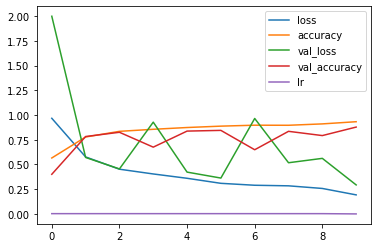

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')
preds = model.predict(test,verbose=1)

54/54 [==============================] - 10s 178ms/step - loss: 0.3828 - accuracy: 0.8645
The testing accuracy is : 86.4546537399292 %
54/54 [==============================] - 10s 155ms/step


In [ ]:
from keras.models import load_model  
model = load_model('checkpointCNN1.h5')
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')
preds2 = model.predict(test,verbose=1)

54/54 [==============================] - 9s 148ms/step - loss: 0.3828 - accuracy: 0.8645
The testing accuracy is : 86.4546537399292 %
54/54 [==============================] - 9s 146ms/step


In [ ]:
import numpy as np
rounded_labels=np.argmax(preds, axis=1)
rounded_labels[1]

rounded_labels2=np.argmax(preds2, axis=1)
rounded_labels2[1]

3

In [ ]:
from sklearn.metrics import confusion_matrix
cmm = confusion_matrix(rounded_labels, test.classes)
cmm

cnn = confusion_matrix(rounded_labels2, test.classes)
cnn

array([[198,   4,   7,   8],
       [  0, 181,   1,   1],
       [  7,   5, 162,  14],
       [  4,  31,  33, 193]])

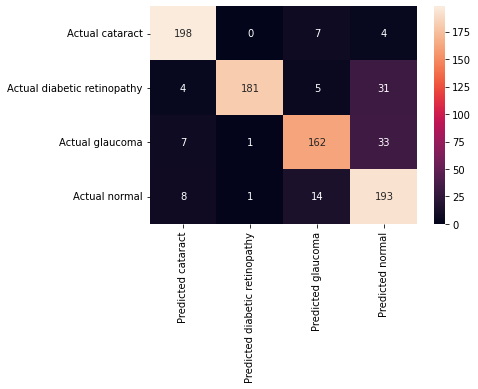

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, rounded_labels, labels=[0, 1, 2, 3]),index=["Actual cataract", "Actual diabetic retinopathy", "Actual glaucoma", "Actual normal"],
columns=["Predicted cataract", "Predicted diabetic retinopathy", "Predicted glaucoma", "Predicted normal"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

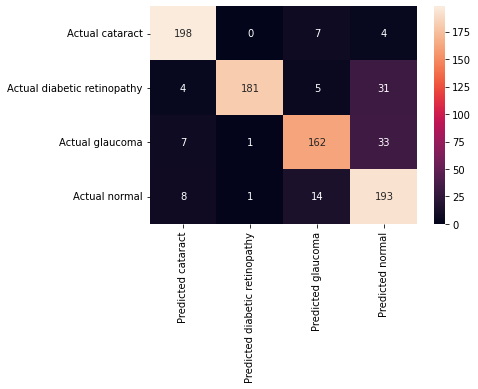

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, rounded_labels2, labels=[0, 1, 2, 3]),index=["Actual cataract", "Actual diabetic retinopathy", "Actual glaucoma", "Actual normal"],
columns=["Predicted cataract", "Predicted diabetic retinopathy", "Predicted glaucoma", "Predicted normal"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=rounded_labels,target_names =["cataract", "diabetic retinopathy", "glaucoma", "normal"]))

print(classification_report(y_true=test.classes,y_pred=rounded_labels2,target_names =["cataract", "diabetic retinopathy", "glaucoma", "normal"]))

                      precision    recall  f1-score   support

            cataract       0.91      0.95      0.93       209
diabetic retinopathy       0.99      0.82      0.90       221
            glaucoma       0.86      0.80      0.83       203
              normal       0.74      0.89      0.81       216

            accuracy                           0.86       849
           macro avg       0.88      0.86      0.87       849
        weighted avg       0.88      0.86      0.87       849

                      precision    recall  f1-score   support

            cataract       0.91      0.95      0.93       209
diabetic retinopathy       0.99      0.82      0.90       221
            glaucoma       0.86      0.80      0.83       203
              normal       0.74      0.89      0.81       216

            accuracy                           0.86       849
           macro avg       0.88      0.86      0.87       849
        weighted avg       0.88      0.86      0.87       849

